In [1]:
from einops import rearrange, reduce, repeat
import qutip
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.interpolate import interp1d
from scipy.integrate import odeint

In [3]:
no_cav = 3
cav_dim = 3

g = 5                #gamma
rg = g**0.5

# Deveriving $g_i(t)$ coupling functions

In [4]:
t_final = 10
res = 500
c_time = np.linspace(0, t_final, res)
corel_c = qutip.destroy(2)
corel = qutip.correlation_2op_2t(qutip.qeye(2), qutip.fock(2,1), c_time, c_time, [rg*corel_c,], rg*corel_c.dag(), rg*corel_c)

In [41]:
#converting qutip format to t,t' format in paper
tdash_corel = np.zeros_like(corel)
for i in range(res):
    tdash_corel[i][i:] = corel[i][:(res-i)]
tdash_corel = tdash_corel + tdash_corel.T - (tdash_corel*np.eye(res))


n, func = np.linalg.eig(tdash_corel)
n = n/np.sum(n)                                     #renormalising for one photon
func_ = func/np.sqrt(c_time[1])                       #renormalising integration to one

v_funct = dict()
alpha_funct = dict()
g_funct = dict()
# format -> cav_no(i) influenced by cav_no(j)
# cav_no(i) if influenced by 0, means uninfluenced
#cavities are indexed 1 to no_cav

def da_vi_j(alpha, t ,i ,j ):
    da_vi_j = -(g_funct[j](t) * v_funct[i,j-1](t)) - (0.5*alpha*(g_funct[j](t))**2)
    return da_vi_j

def g_cnstr(v_list):
    return np.real(-v_list/(c_time[1]*np.cumsum(v_list**2))**0.5)

for i in range(1, no_cav+1):
    #cavity no is i 
    v_funct[i,0] = interp1d(c_time, np.real(func_[:,i-1]), kind='cubic', fill_value='extrapolate')

    for j in range(1,i):
        #cavity no i, influenced by cavity j
        # till j = i-1

        # generate alpha[i,j]
        alpha_list = odeint(da_vi_j,0,c_time,args=(i,j))[:,0]
        alpha_funct[i,j] = interp1d(c_time, alpha_list, kind='cubic',fill_value='extrapolate')

        #generate v[i,j]
        v_funct[i,j] = interp1d(c_time, (v_funct[i,j-1](c_time) + (g_funct[j](c_time) * alpha_funct[i,j](c_time))), kind='cubic',fill_value='extrapolate')

    # generate g[i]
    g_funct[i] = qutip.interpolate.Cubic_Spline(0, t_final, 1 + 0*g_cnstr(v_funct[i,i-1](c_time)))

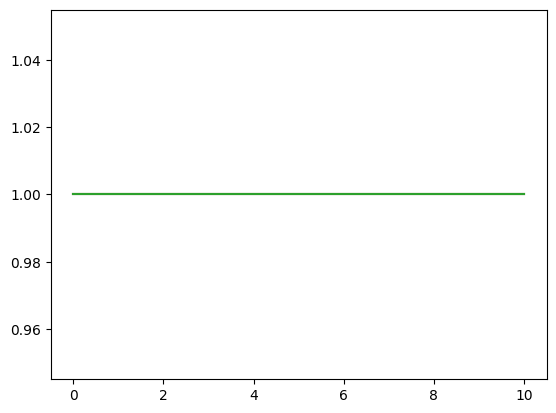

In [42]:
for i in range(1,1+no_cav):
    plt.plot(c_time, g_funct[i](c_time))

# Functions

In [43]:
def add_mpo( A, B, is_first = False, is_last = False):
  s0, s1, s2 = A.shape[:3]

  if is_first:
    #immutable axes are 0,2
    C = np.append(A, B, axis=1)

  elif is_last:
    #immutable axes are 1,2
    C = np.append(A, B, axis=0)

  else:
    #immutable axes are 1,3
    s3 = A.shape[3]
    top = np.append( A, np.zeros((B.shape[0],s1,A.shape[2],s3)), axis=0)
    bottom = np.append(np.zeros((A.shape[0],s1,B.shape[2],s3)),B, axis =0)
    C = np.append( top, bottom, axis=2 )

  return C

In [44]:
def svd_red(mpo_list, no_cav = no_cav, cav_dim = cav_dim):
    #Assuming there are at least two cavitites

    red_mpo_list = list()

    u, s, v = np.linalg.svd(rearrange(np.einsum('a b c, b d e f-> a d e c f', mpo_list[0], mpo_list[1]), 'a d e c f-> (a c) (d e f)'), full_matrices=False)
    red_mpo_list.append(rearrange(u,'(a c) g-> a g c', a=2, c=2))
    red_mpo_list.append(rearrange(np.diag(s)@v, 'g (d e f)-> g d e f', d=cav_dim, f=cav_dim))

    for i in range(1,no_cav):

        if i == no_cav-1:
            u, s, v = np.linalg.svd(rearrange(np.einsum('a b c d, c e f -> a b e d f ', red_mpo_list[-1], mpo_list[i+1]), 'a b e d f-> (a b d) (e f)'), full_matrices=False)
            red_mpo_list.pop()
            red_mpo_list.append( rearrange(u, '(a b d) h-> a b h d', b=cav_dim, d=cav_dim))
            red_mpo_list.append( rearrange(np.diag(s)@v, 'h (e f)-> h e f', e=cav_dim, f=cav_dim))

        else:
            u, s, v = np.linalg.svd(rearrange(np.einsum('a b c d, c e f g-> a b e f d g', red_mpo_list[-1], mpo_list[i+1]), 'a b e f d g-> (a b d) (e f g)'), full_matrices=False)
            red_mpo_list.pop()
            red_mpo_list.append( rearrange(u, '(a b d) h-> a b h d', b=cav_dim, d=cav_dim))
            red_mpo_list.append( rearrange(np.diag(s)@v, 'h (e f g)-> h e f g', e=cav_dim, g=cav_dim))

    return red_mpo_list


In [45]:
#overall svd, too slow, redundant for genralised cavities
def svd(mpo_x):
    u, s, v = np.linalg.svd((rearrange(mpo_x, 'a c e g b d f h-> (a b c d e f) (g h)')), full_matrices=False)
    cell_0 = rearrange(np.diag(s)@v, 'c (a b)-> c a b', a=3, b=3)

    u, s, v = np.linalg.svd((rearrange(u, '(a b c d e f) g -> (a b c d) (e f g)', a=2, b=2, c=3, d=3, e=3, f=3)), full_matrices=False)
    cell_1 = rearrange(np.diag(s)@v, 's (e f g)-> s e g f', e=3, f=3)

    u, s, v = np.linalg.svd((rearrange(u, '(a b c d) s -> (a b) (c d s)', a=2, b=2, c=3, d=3)), full_matrices=False)
    cell_2 = rearrange(np.diag(s)@v, 't (c d s)-> t c s d', c=3, d=3)

    cell_3 = rearrange(u, '(a b) t-> a t b', a=2, b=2)

    return cell_3, cell_2, cell_1, cell_0

In [46]:
#not general
def mpo_make(cell_3, cell_2, cell_1, cell_0):
    return np.einsum('a t b, t c s d, s e q f, q g h-> a c e g b d f h', cell_3, cell_2, cell_1, cell_0 )

In [47]:
def exp_value(mpo_list, cav_no = -1):

    mpo_copy = list(mpo_list)

    if cav_no == 0:
        mpo_copy[0] = np.einsum( 'a b, b c d-> a c d', cd@c, mpo_copy[0])
    elif cav_no == no_cav:
        mpo_copy[cav_no] = np.einsum( 'a c, b c d-> b a d', ad@a, mpo_copy[cav_no])
    elif cav_no < 0:
        pass
    else:
        mpo_copy[cav_no] = np.einsum( 'a c, b c d e-> b a d e', ad@a, mpo_copy[cav_no])

    mpo_copy[0] = np.einsum( 'a b a', mpo_copy[0])

    for i in range(1,no_cav+1):
        if i == (no_cav):
            mpo_copy[i] =  np.einsum('a, a b b', mpo_copy[i-1], mpo_copy[i])
        else:
            mpo_copy[i] = np.einsum('a, a b c b', mpo_copy[i-1], mpo_copy[i])

    return mpo_copy[-1]


In [48]:
def g1(t=0):
    return 0

def g2(t=0):
    return 0

def g3(t=0):
    return 0


# Initialising system

In [94]:
#atom-cavity list
ac_list = list()

ac_list.append(qutip.fock_dm(2,1).full())
for i in range(no_cav):
    ac_list.append(qutip.fock_dm(cav_dim,1).full())

In [95]:
# mpo conversion and storage

mpo_0 = np.einsum('a b, c d, e f, g h-> a c e g b d f h', ac_list[0], ac_list[1], ac_list[2], ac_list[3])

u, s, v = np.linalg.svd((rearrange(mpo_0, 'a c e g b d f h-> (a b c d e f) (g h)')), full_matrices=False)
cell_0 = rearrange(np.diag(s)@v, 'c (a b)-> c a b', a=3, b=3)

u, s, v = np.linalg.svd((rearrange(u, '(a b c d e f) g -> (a b c d) (e f g)', a=2, b=2, c=3, d=3, e=3, f=3)), full_matrices=False)
cell_1 = rearrange(np.diag(s)@v, 's (e f g)-> s e g f', e=3, f=3)

u, s, v = np.linalg.svd((rearrange(u, '(a b c d) s -> (a b) (c d s)', a=2, b=2, c=3, d=3)), full_matrices=False)
cell_2 = rearrange(np.diag(s)@v, 't (c d s)-> t c s d', c=3, d=3)

cell_3 = rearrange(u, '(a b) t-> a t b', a=2, b=2)

ac_list = [cell_3, cell_2, cell_1, cell_0]

In [96]:
#atom_a 
c = qutip.destroy(2).full()
#atom_a = np.eye(2)
#atom_adag
cd = qutip.destroy(2).dag().full()
#atom_adag = np.eye(2)
#cav_a 
a = qutip.destroy(3).full()
#cav_a = np.eye(3)
#cav_adag 
ad = qutip.destroy(3).dag().full()
#cav_adag = np.eye(3)

In [97]:
n_sum = int((no_cav*0.5*(no_cav+1)))
mpo_dim = 1 + no_cav + n_sum
zero_mpo_matrix = np.array( list([ list([ np.zeros((cav_dim,cav_dim))])*mpo_dim ])*mpo_dim ) *0j

In [98]:
no_cav = 3
cav_dim = 3

In [116]:
tem = 1

In [117]:
g_funct[1](1)

1.0

In [118]:
pre_term = dict()
post_term = dict()
L_term = dict()
Ld_term = dict()

pre_term[0] = -0.5 * rearrange( np.array( list([g*cd@c,]) + (list([rg*c,])*no_cav) + (list([np.eye(2),])*n_sum) ), 'c a b-> a c b')
post_term[0] = -0.5 * rearrange( np.array( list([g*cd@c,]) + (list([rg*cd,])*no_cav) + (list([np.eye(2),])*n_sum) ), 'c a b-> a c b')
L_term[0] = rearrange( np.array( list([rg*c,]) +  (list([np.eye(2),])*no_cav) ) , 'c a b-> a c b')
Ld_term[0] = rearrange( np.array( list([rg*cd,]) +  (list([np.eye(2),])*no_cav) ) , 'c a b-> a c b')

for i in range(1,no_cav+1):
    if i == no_cav:
        #last term
        pre_term[i] = np.array( list([ np.zeros((cav_dim,cav_dim))])*mpo_dim )* 0j
        pre_term[i][0][:][:] = np.eye(cav_dim)

        post_term[i] = np.array( list([ np.zeros((cav_dim,cav_dim))])*mpo_dim )* 0j
        post_term[i][0][:][:] = np.eye(cav_dim)

        L_term[i] = np.array((list([np.eye(cav_dim),])*(no_cav+1)) ) * 0j
        Ld_term[i] = np.array((list([np.eye(cav_dim),])*(no_cav+1)) ) * 0j

        for j in range(1, no_cav+1):
            if j==i:
                pre_term[i][j][:][:] = ad * g_funct[i](tem)
                post_term[i][j][:][:] = a * g_funct[i](tem)
                L_term[i][j][:][:] = a * g_funct[i](tem)
                Ld_term[i][j][:][:] = ad * g_funct[i](tem)
            else:
                pre_term[i][j][:][:] = np.eye(cav_dim)
                post_term[i][j][:][:] = np.eye(cav_dim)

        for s in range(no_cav):
            for t in range(s+1):
            
                index = 1 + no_cav + t + int(0.5*s*(s+1))

                if s+1 == i:
                    if t+1 == i:
                        pre_term[i][index][:][:] = ad@a * g_funct[i](tem)**2
                    else:
                        pre_term[i][index][:][:] = ad * g_funct[i](tem)

                else:
                    if t+1 == i:
                        pre_term[i][index][:][:] = a * g_funct[i](tem)
                    else:
                        pre_term[i][index][:][:] = np.eye(cav_dim)

            for t in range(no_cav-s):

                index_ = 1 + (no_cav*(1+s)) - int(0.5*s*(s-1)) + t

                if s+1 == i:
                    if t+1+s == i:
                        post_term[i][index_][:][:] = ad@a * g_funct[i](tem)**2
                    else:
                        post_term[i][index_][:][:] = ad * g_funct[i](tem)

                else:
                    if t+1+s == i:
                        post_term[i][index_][:][:] = a * g_funct[i](tem)
                    else:
                        post_term[i][index_][:][:] = np.eye(cav_dim)
    else:

        pre_term[i] = np.copy(zero_mpo_matrix)
        post_term[i] = np.copy(zero_mpo_matrix)
        L_term[i] = np.array( list([ list([ np.zeros((cav_dim,cav_dim))])*(no_cav+1) ])*(no_cav+1) ) *0j
        Ld_term[i] = np.array( list([ list([ np.zeros((cav_dim,cav_dim))])*(no_cav+1) ])*(no_cav+1) ) *0j

        pre_term[i][0][0][:][:] = np.eye(cav_dim)
        post_term[i][0][0][:][:] = np.eye(cav_dim)
        L_term[i][0][0][:][:] = np.eye(cav_dim)
        Ld_term[i][0][0][:][:] = np.eye(cav_dim)

        for j in range(1, no_cav+1):
            if j==i:
                pre_term[i][j][j][:][:] = ad * g_funct[i](tem)
                post_term[i][j][j][:][:] = a * g_funct[i](tem)
                L_term[i][j][j][:][:] = a * g_funct[i](tem)
                Ld_term[i][j][j][:][:] = ad * g_funct[i](tem)
            else:
                pre_term[i][j][j][:][:] = np.eye(cav_dim)
                post_term[i][j][j][:][:] = np.eye(cav_dim)
                L_term[i][j][j][:][:] = np.eye(cav_dim)
                Ld_term[i][j][j][:][:] = np.eye(cav_dim)
            
        for s in range(no_cav):
            for t in range(s+1):
            
                index = 1 + no_cav + t + int(0.5*s*(s+1))

                if s+1 == i:
                    if t+1 == i:
                        pre_term[i][index][index][:][:] = ad@a * g_funct[i](tem)**2
                    else:
                        pre_term[i][index][index][:][:] = ad * g_funct[i](tem)

                else:
                    if t+1 == i:
                        pre_term[i][index][index][:][:] = a * g_funct[i](tem)
                    else:
                        pre_term[i][index][index][:][:] = np.eye(cav_dim)
            
            for t in range(no_cav-s):

                index_ = 1 + (no_cav*(1+s)) - int(0.5*s*(s-1)) + t

                if s+1 == i:
                    if t+1+s == i:
                        post_term[i][index_][index_][:][:] = ad@a * g_funct[i](tem)**2
                    else:
                        post_term[i][index_][index_][:][:] = ad * g_funct[i](tem)

                else:
                    if t+1+s == i:
                        post_term[i][index_][index_][:][:] = a * g_funct[i](tem)
                    else:
                        post_term[i][index_][index_][:][:] = np.eye(cav_dim)
        
        pre_term[i] = rearrange(pre_term[i], 'a b c d-> a c b d')
        post_term[i] = rearrange(post_term[i], 'a b c d-> a c b d')
        L_term[i] = rearrange(L_term[i], 'a b c d-> a c b d')
        Ld_term[i] = rearrange(Ld_term[i], 'a b c d-> a c b d')
        


In [119]:
def time_update_mpo(t_ = 0):

    for i in range(1,no_cav+1):
        if i == no_cav:
            for j in range(1, no_cav+1):
                if j==i:
                    pre_term[i][j][:][:] = ad * g_funct[i](t_)
                    post_term[i][j][:][:] = a * g_funct[i](t_)
                    L_term[i][j][:][:] = a * g_funct[i](t_)
                    Ld_term[i][j][:][:] = ad * g_funct[i](t_)
            for s in range(no_cav):
                for t in range(s+1):
                
                    index = 1 + no_cav + t + int(0.5*s*(s+1))

                    if s+1 == i:
                        if t+1 == i:
                            pre_term[i][index][:][:] = ad@a * g_funct[i](t_)**2
                        else:
                            pre_term[i][index][:][:] = ad * g_funct[i](t_)

                    else:
                        if t+1 == i:
                            pre_term[i][index][:][:] = a * g_funct[i](t_)
                for t in range(no_cav-s):

                    index_ = 1 + (no_cav*(1+s)) - int(0.5*s*(s-1)) + t

                    if s+1 == i:
                        if t+1+s == i:
                            post_term[i][index_][:][:] = ad@a * g_funct[i](t_)**2
                        else:
                            post_term[i][index_][:][:] = ad * g_funct[i](t_)

                    else:
                        if t+1+s == i:
                            post_term[i][index_][:][:] = a * g_funct[i](t_)
        else:
            for j in range(1, no_cav+1):
                if j==i:
                    pre_term[i][j,:,j,:] = ad * g_funct[i](t_)
                    post_term[i][j,:,j,:]  = a * g_funct[i](t_)
                    L_term[i][j,:,j,:]  = a * g_funct[i](t_)
                    Ld_term[i][j,:,j,:]  = ad * g_funct[i](t_)       
            for s in range(no_cav):
                for t in range(s+1):
                
                    index = 1 + no_cav + t + int(0.5*s*(s+1))

                    if s+1 == i:
                        if t+1 == i:
                            pre_term[i][index,:,index,:] = ad@a * g_funct[i](t_)**2
                        else:
                            pre_term[i][index,:,index,:] = ad * g_funct[i](t_)

                    else:
                        if t+1 == i:
                            pre_term[i][index,:,index,:] = a * g_funct[i](t_)
                
                for t in range(no_cav-s):

                    index_ = 1 + (no_cav*(1+s)) - int(0.5*s*(s-1)) + t

                    if s+1 == i:
                        if t+1+s == i:
                            post_term[i][index_,:,index_,:] = ad@a * g_funct[i](t_)**2
                        else:
                            post_term[i][index_,:,index_,:] = ad * g_funct[i](t_)

                    else:
                        if t+1+s == i:
                            post_term[i][index_,:,index_,:] = a * g_funct[i](t_)    


In [120]:
def drhodt_(mpo_list, t_=1000):

    term1_ = dict()
    term2_ = dict()
    term3_ = dict()

    #time_update_mpo(t_)

    term1_[0] = rearrange(np.einsum('a b c, c d e-> a b d e', pre_term[0], ac_list[0]), 'a b d e-> a (b d) e')
    term2_[0] = rearrange(np.einsum('a b c, c d e-> a b d e', ac_list[0], post_term[0]), 'a b d e-> a (b d) e')
    term3_[0] = rearrange(np.einsum('a b c, c d e, e f g-> a b d f g', L_term[0], ac_list[0], Ld_term[0]), 'a b d f g-> a (b d f) g')

    for i in range(1, no_cav+1):
        if i == no_cav:
            term1_[i] = rearrange(np.einsum('a b c, d c e-> a d b e', pre_term[i], ac_list[i]), 'a d b e-> (a d) b e')
            term2_[i] = rearrange(np.einsum('a b c, d c e-> a d b e', ac_list[i], post_term[i]), 'a d b e-> (a d) b e')
            term3_[i] = rearrange(np.einsum('a b c, d c e, f e g-> a d f b g', L_term[i], ac_list[i], Ld_term[i]), 'a d f b g-> (a d f) b g')
        else:
            term1_[i] = rearrange(np.einsum('a b c d, e d f g-> a e b c f g', pre_term[i], ac_list[i]), 'a e b c f g-> (a e) b (c f) g')
            term2_[i] = rearrange(np.einsum('a b c d, e d f g-> a e b c f g', ac_list[i], post_term[i]), 'a e b c f g-> (a e) b (c f) g')
            term3_[i] = rearrange(np.einsum('a b c d, f d e g, h g i j-> a f h b c e i j', L_term[i], ac_list[i], Ld_term[i]), 'a f h b c e i j-> (a f h) b (c e i) j')

    term1_ = svd_red(term1_)
    term2_ = svd_red(term2_)
    term3_ = svd_red(term3_)

    sum_term = dict()
    sum_term[0] = add_mpo(add_mpo(term1[0], term2[0], is_first=True), term3[0], is_first=True) 
    for i in range(1, no_cav+1):
        if i == no_cav:
            sum_term[i] =  add_mpo(add_mpo(term1[i], term2[i], is_last=True), term3[i], is_last=True) 
        else:
            sum_term[i] = add_mpo(add_mpo(term1[i], term2[i]), term3[i]) 
    sum_term = svd_red(sum_term)

    return sum_term

In [121]:


pre_term1 = np.copy(zero_mpo_matrix)
pre_term1[0][0][:][:] = np.eye(3)
pre_term1[1][1][:][:] = ad * g1()
pre_term1[2][2][:][:] = np.eye(3)
pre_term1[3][3][:][:] = np.eye(3)
pre_term1[4][4][:][:] = ad@a * g1()**2
pre_term1[5][5][:][:] = a * g1()
pre_term1[6][6][:][:] = np.eye(3)
pre_term1[7][7][:][:] = a * g1()
pre_term1[8][8][:][:] = np.eye(3)
pre_term1[9][9][:][:] = np.eye(3)

pre_term2 = np.copy(zero_mpo_matrix)
pre_term2[0][0][:][:] = np.eye(3)
pre_term2[1][1][:][:] = np.eye(3)
pre_term2[2][2][:][:] = ad * g2()
pre_term2[3][3][:][:] = np.eye(3)
pre_term2[4][4][:][:] = np.eye(3)
pre_term2[5][5][:][:] = ad * g2()
pre_term2[6][6][:][:] = ad@a * g2()**2
pre_term2[7][7][:][:] = np.eye(3)
pre_term2[8][8][:][:] = a * g2()
pre_term2[9][9][:][:] = np.eye(3)

post_term1 = np.copy(zero_mpo_matrix)
post_term1[0][0][:][:] = np.eye(3)
post_term1[1][1][:][:] = a * g1()
post_term1[2][2][:][:] = np.eye(3)
post_term1[3][3][:][:] = np.eye(3)
post_term1[4][4][:][:] = ad@a * (g1()**2)
post_term1[5][5][:][:] = ad * g1()
post_term1[6][6][:][:] = ad * g1()
post_term1[7][7][:][:] = np.eye(3)
post_term1[8][8][:][:] = np.eye(3)
post_term1[9][9][:][:] = np.eye(3)

post_term2 = np.copy(zero_mpo_matrix)
post_term2[0][0][:][:] = np.eye(3)
post_term2[1][1][:][:] = np.eye(3)
post_term2[2][2][:][:] = a * g2()
post_term2[3][3][:][:] = np.eye(3)
post_term2[4][4][:][:] = np.eye(3)
post_term2[5][5][:][:] = a * g2()
post_term2[6][6][:][:] = np.eye(3)
post_term2[7][7][:][:] = ad@a * (g2()**2)
post_term2[8][8][:][:] = ad * g2()
post_term2[9][9][:][:] = np.eye(3)

L_term1 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
L_term1[0][0][:][:] = np.eye(3)
L_term1[1][1][:][:] = g1() * a
L_term1[2][2][:][:] = np.eye(3)
L_term1[3][3][:][:] = np.eye(3)

L_term2 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
L_term2[0][0][:][:] = np.eye(3)
L_term2[1][1][:][:] = np.eye(3)
L_term2[2][2][:][:] = g2() * a
L_term2[3][3][:][:] = np.eye(3)

Ld_term1 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
Ld_term1[0][0][:][:] = np.eye(3)
Ld_term1[1][1][:][:] = g1() * ad
Ld_term1[2][2][:][:] = np.eye(3)
Ld_term1[3][3][:][:] = np.eye(3)

Ld_term2 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
Ld_term2[0][0][:][:] = np.eye(3)
Ld_term2[1][1][:][:] = np.eye(3)
Ld_term2[2][2][:][:] = g2() * ad
Ld_term2[3][3][:][:] = np.eye(3)


In [122]:
pre_mpo = list([
                -0.5 * rearrange( np.array( [ g*cd@c, rg*c, rg*c, rg*c, np.eye(2), np.eye(2), np.eye(2),np.eye(2),np.eye(2),np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(pre_term1, 'a b c d-> a c b d') , 

                rearrange(pre_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*ad, np.eye(3), np.eye(3), np.eye(3), g3()*ad, g3()*ad, (g3()**2 * ad@a) ] )    
])

post_mpo = list([
                -0.5 * rearrange( np.array( [ g*cd@c, rg*cd, rg*cd, rg*cd, np.eye(2), np.eye(2), np.eye(2),np.eye(2),np.eye(2),np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(post_term1, 'a b c d-> a c b d') , 

                rearrange(post_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*a, np.eye(3), np.eye(3), a*g3(), np.eye(3), g3()*a, g3()**2 * ad@a ] )   
])

L_mpo = list([
                rearrange( np.array( [ rg*c, np.eye(2), np.eye(2), np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(L_term1, 'a b c d-> a c b d') , 

                rearrange(L_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*a ] ) 
])

Ld_mpo = list([
                rearrange( np.array( [ rg*cd, np.eye(2), np.eye(2), np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(Ld_term1, 'a b c d-> a c b d') , 

                rearrange(Ld_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*ad ] )
])

In [123]:
term1 = list([
            rearrange(np.einsum('a b c, c d e-> a b d e', pre_mpo[0], ac_list[0]), 'a b d e-> a (b d) e'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', pre_mpo[1], ac_list[1]), 'a e b c f g-> (a e) b (c f) g'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', pre_mpo[2], ac_list[2]), 'a e b c f g-> (a e) b (c f) g'),
            rearrange(np.einsum('a b c, d c e-> a d b e', pre_mpo[3], ac_list[3]), 'a d b e-> (a d) b e'), 
])

term2 = list([
            rearrange(np.einsum('a b c, c d e-> a b d e', ac_list[0], post_mpo[0]), 'a b d e-> a (b d) e'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', ac_list[1], post_mpo[1]), 'a e b c f g-> (a e) b (c f) g'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', ac_list[2], post_mpo[2]), 'a e b c f g-> (a e) b (c f) g'),
            rearrange(np.einsum('a b c, d c e-> a d b e', ac_list[3], post_mpo[3]), 'a d b e-> (a d) b e'), 
])

term3 = list([
            rearrange(np.einsum('a b c, c d e, e f g-> a b d f g', L_mpo[0], ac_list[0], Ld_mpo[0]), 'a b d f g-> a (b d f) g'),
            rearrange(np.einsum('a b c d, f d e g, h g i j-> a f h b c e i j', L_mpo[1], ac_list[1], Ld_mpo[1]), 'a f h b c e i j-> (a f h) b (c e i) j'),
            rearrange(np.einsum('a b c d, f d e g, h g i j-> a f h b c e i j', L_mpo[2], ac_list[2], Ld_mpo[2]), 'a f h b c e i j-> (a f h) b (c e i) j'),
            rearrange(np.einsum('a b c, d c e, f e g-> a d f b g', L_mpo[3], ac_list[3], Ld_mpo[3]), 'a d f b g-> (a d f) b g')
])

In [124]:
for i in range(no_cav+1):
    print("----",i,"----")
    print("Term1 ",term1[i].shape)
    print("Term2 ",term2[i].shape)
    print("Term3 ",term3[i].shape)

---- 0 ----
Term1  (2, 40, 2)
Term2  (2, 40, 2)
Term3  (2, 64, 2)
---- 1 ----
Term1  (40, 3, 360, 3)
Term2  (40, 3, 360, 3)
Term3  (64, 3, 576, 3)
---- 2 ----
Term1  (360, 3, 90, 3)
Term2  (360, 3, 90, 3)
Term3  (576, 3, 144, 3)
---- 3 ----
Term1  (90, 3, 3)
Term2  (90, 3, 3)
Term3  (144, 3, 3)


In [125]:
def drhodt(mpo_list):
    
    term1 = list([
                rearrange(np.einsum('a b c, c d e-> a b d e', pre_mpo[0], mpo_list[0]), 'a b d e-> a (b d) e'), 
                rearrange(np.einsum('a b c d, e d f g-> a e b c f g', pre_mpo[1], mpo_list[1]), 'a e b c f g-> (a e) b (c f) g'), 
                rearrange(np.einsum('a b c d, e d f g-> a e b c f g', pre_mpo[2], mpo_list[2]), 'a e b c f g-> (a e) b (c f) g'),
                rearrange(np.einsum('a b c, d c e-> a d b e', pre_mpo[3], mpo_list[3]), 'a d b e-> (a d) b e'), 
    ])

    term2 = list([
                rearrange(np.einsum('a b c, c d e-> a b d e', mpo_list[0], post_mpo[0]), 'a b d e-> a (b d) e'), 
                rearrange(np.einsum('a b c d, e d f g-> a e b c f g', mpo_list[1], post_mpo[1]), 'a e b c f g-> (a e) b (c f) g'), 
                rearrange(np.einsum('a b c d, e d f g-> a e b c f g', mpo_list[2], post_mpo[2]), 'a e b c f g-> (a e) b (c f) g'),
                rearrange(np.einsum('a b c, d c e-> a d b e', mpo_list[3], post_mpo[3]), 'a d b e-> (a d) b e'), 
    ])

    term3 = list([
                rearrange(np.einsum('a b c, c d e, e f g-> a b d f g', L_mpo[0], mpo_list[0], Ld_mpo[0]), 'a b d f g-> a (b d f) g'),
                rearrange(np.einsum('a b c d, f d e g, h g i j-> a f h b c e i j', L_mpo[1], mpo_list[1], Ld_mpo[1]), 'a f h b c e i j-> (a f h) b (c e i) j'),
                rearrange(np.einsum('a b c d, f d e g, h g i j-> a f h b c e i j', L_mpo[2], mpo_list[2], Ld_mpo[2]), 'a f h b c e i j-> (a f h) b (c e i) j'),
                rearrange(np.einsum('a b c, d c e, f e g-> a d f b g', L_mpo[3], mpo_list[3], Ld_mpo[3]), 'a d f b g-> (a d f) b g')
    ])

    term1 = svd_red(term1)
    term2 = svd_red(term2)
    term3 = svd_red(term3)

    sum_term = list()
    sum_term.append( add_mpo(add_mpo(term1[0], term2[0], is_first=True), term3[0], is_first=True) )
    for i in range(1, no_cav+1):
        if i == no_cav:
            sum_term.append( add_mpo(add_mpo(term1[i], term2[i], is_last=True), term3[i], is_last=True) )
        else:
            sum_term.append( add_mpo(add_mpo(term1[i], term2[i]), term3[i]) )
    sum_term = svd_red(sum_term)

    return sum_term

In [126]:
exp_value_list = list()
exp_value_list.append(list())
for i in range(no_cav):
    exp_value_list.append(list())

In [127]:
##With dynamic mpo

time = np.linspace(0,10,10)
dt = time[1]
#dt = 0
test_list = list()
mpo_i = list(ac_list)

test_list.append(exp_value(mpo_i))

for i in range(no_cav+1):
    exp_value_list[i].append(exp_value(mpo_i, i))

for i in time[1:]:

  drho_list = drhodt_(mpo_i)

  sum_term = list()
  sum_term.append( add_mpo(dt*drho_list[0], mpo_i[0], is_first=True) )
  for i in range(1, no_cav+1):
    if i == no_cav:
      sum_term.append( add_mpo(drho_list[i], mpo_i[i], is_last=True) )
    else:
      sum_term.append( add_mpo(drho_list[i], mpo_i[i]) )
  sum_term = svd_red(sum_term)

  
  
  mpo_i[0] = sum_term[0]/exp_value(sum_term)
  for i in range(1,no_cav+1):
    mpo_i[i] = sum_term[i]
    

  norm = exp_value(mpo_i)
  test_list.append(norm)

  for i in range(no_cav+1):
    exp_value_list[i].append(exp_value(mpo_i, i))


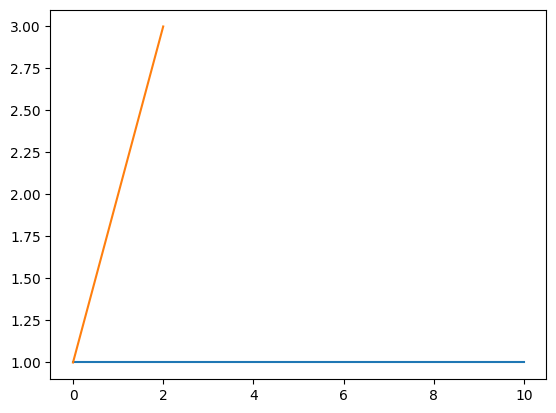

In [128]:
plt.plot(time, test_list)
plt.plot([0,1,2],[1,2,3])

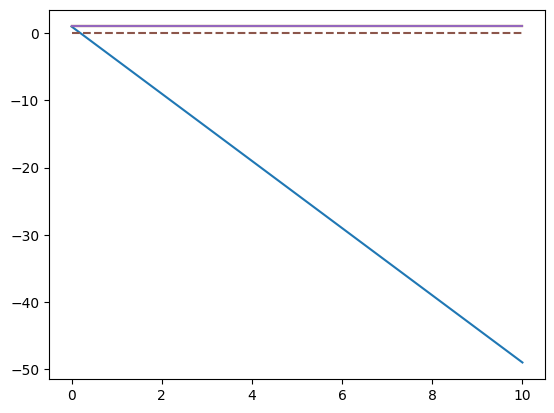

In [129]:
plt.plot(time, exp_value_list[0])
plt.plot(time,exp_value_list[1])
plt.plot(time,exp_value_list[2])
plt.plot(time,exp_value_list[3])
plt.plot(time, test_list)
plt.plot(time, time*0, '--')

In [122]:
#static no of cavities

time = np.linspace(0,10,50)
dt = time[1]
#dt = 0
test_list = list()
mpo_i = list(ac_list)

test_list.append(exp_value(mpo_i))

for i in range(no_cav+1):
    exp_value_list[i].append(exp_value(mpo_i, i))

for i in time[1:]:

  drho_list = drhodt(mpo_i)

  sum_term = list()
  sum_term.append( add_mpo(dt*drho_list[0], mpo_i[0], is_first=True) )
  for i in range(1, no_cav+1):
    if i == no_cav:
      sum_term.append( add_mpo(drho_list[i], mpo_i[i], is_last=True) )
    else:
      sum_term.append( add_mpo(drho_list[i], mpo_i[i]) )
  sum_term = svd_red(sum_term)

  
  
  mpo_i[0] = sum_term[0]/exp_value(sum_term)
  for i in range(1,no_cav+1):
    mpo_i[i] = sum_term[i]
    

  norm = exp_value(mpo_i)
  test_list.append(norm)

  for i in range(no_cav+1):
    exp_value_list[i].append(exp_value(mpo_i, i))


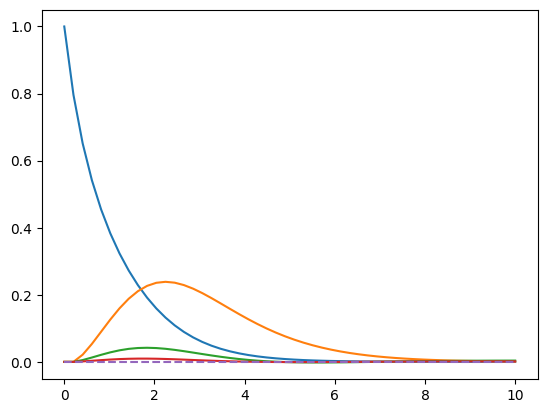

In [125]:
plt.plot(time, exp_value_list[0])
plt.plot(time,exp_value_list[1])
plt.plot(time,exp_value_list[2])
plt.plot(time,exp_value_list[3])
plt.plot(time, time*0, '--')

#Archive